# Data Exploration

Exploring the use of data transformation methods to extract dominant colours from an image

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 25/11/2025   | Martin | Created   | Exploring colour quantisation | 

# Content

* [Introduction](#introduction)

# Finding Dominant Colours

<u>Application Notes</u>

1. Specify the image channel (e.g RGB, BGR, HSV, ...)
2. Resize the image

In [1]:
%load_ext watermark

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
img = cv2.imread("data/img1.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
# Use KMeans clustering to find most common colours
def dominant_colours(img_path, k=10):
  img = cv2.imread(f"data/{img_path}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Flatten the image
  pixel_list = img.reshape((img.shape[0] * img.shape[1], 3))

  # Fit the quantisation model
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  # Returns the dominant colours
  d_colours = clt.cluster_centers_.astype('uint8')

  # Reconstructs the image
  labels = clt.labels_
  new_colours = d_colours[labels]
  quantised_img = new_colours.reshape((img.shape[0], img.shape[1], 3))
  
  return img, quantised_img
  

In [48]:
K = 5
IMG_PATH = 'img5.jpg'
original_img, quantised_img = dominant_colours(IMG_PATH, k=K)

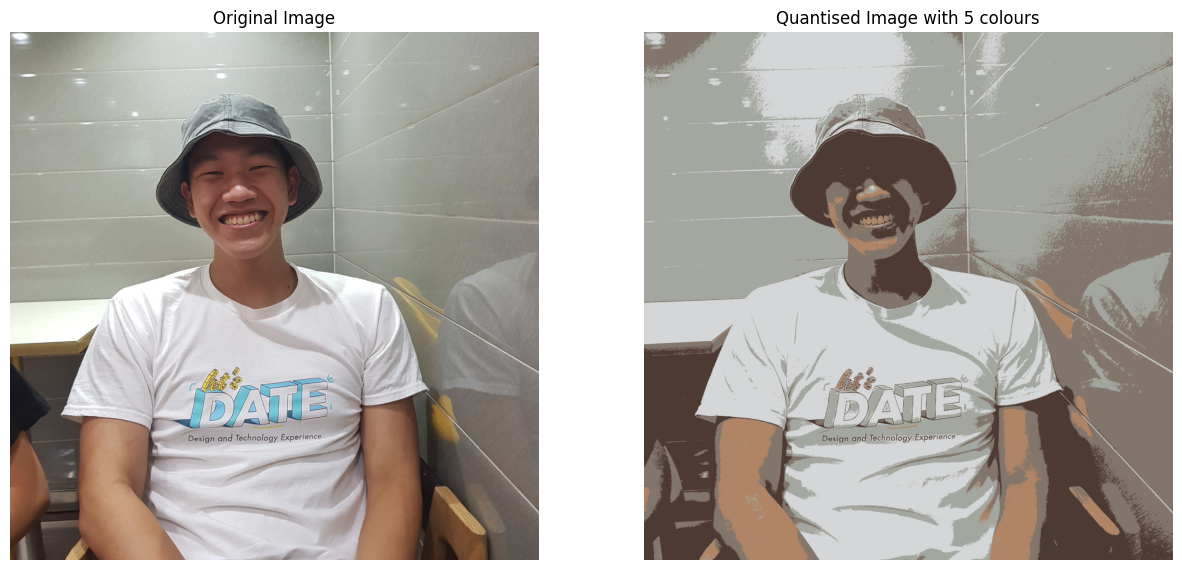

In [49]:
# Display results
plt.figure(figsize=(15, 12))

# Plot the original image
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(original_img)

# Plot the quantised image
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f'Quantised Image with {K} colours')
plt.imshow(quantised_img)

print()

plt.show()

## Add the contoursa and number labels

In [113]:
def generate_paint_by_numbers(img_path, k=10, min_area_threshold=200, source_encoding="RGB"):
  img = cv2.imread(img_path)

  if source_encoding == "BGR":
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # img = cv2.medianBlur(img, 7)

  # Flatten the image
  pixel_list = img.reshape((img.shape[0] * img.shape[1], 3))

  # Fit the quantisation model
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  # Returns the dominant colours
  d_colours = clt.cluster_centers_.astype('uint8')

  # Recreate the image
  labels = clt.labels_
  new_colours = d_colours[labels]
  quantised_img = new_colours.reshape((img.shape[0], img.shape[1], 3))

  # Create the PBN image
  labels_grid = labels.reshape(img.shape[:2])
  canvas = np.ones((img.shape[0], img.shape[1], 3), dtype='uint8') * 255

  for colour_id in range(K):
    # Binary mask - 255 if matches, 0 if not
    mask = np.where(labels_grid == colour_id, 255, 0).astype('uint8')

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
      # Filters out smaller areas
      if cv2.contourArea(contour) > min_area_threshold:
        # Draw the contours on the canvas
        cv2.drawContours(canvas, [contour], -1, (100, 100, 100), 1)

        # Find the center region for each cluster for each colour
        M = cv2.moments(contour)
        if M["m00"] != 0:
          center_X = int(M["m10"] / M["m00"])
          center_Y = int(M["m01"] / M["m00"])

          # Put label in the area
          cv2.putText(
            canvas,
            str(colour_id),
            (center_X, center_Y),
            cv2.FONT_HERSHEY_COMPLEX,
            0.8,
            (0, 0, 0),
            1
          )
  
  # Plot the entire image
  plt.figure(figsize=(20, 15))

  # Original Image
  plt.subplot(2, 2, 1)
  plt.axis('off')
  plt.title("Original Image")
  plt.imshow(img)

  # Original Image
  plt.subplot(2, 2, 2)
  plt.axis('off')
  plt.title("Quantised Image")
  plt.imshow(quantised_img)

  # PBN Image
  plt.subplot(2, 2, 3)
  plt.axis('off')
  plt.title("Paint By The Numbers")
  plt.imshow(canvas)

  # Colour palette
  plt.subplot(2, 2, 4)
  legend_height = 50 * k
  legend_img = np.zeros((legend_height, 200, 3), dtype='uint8') + 255

  for i, colour in enumerate(d_colours):
    cv2.rectangle(legend_img, (10, i*50+10), (60, i*50 + 40), colour.tolist(), -1)
    cv2.putText(
      legend_img,
      f"ID {i}",
      (70, i*50 + 35),
      cv2.FONT_HERSHEY_SIMPLEX, 
      0.5,
      (0, 0, 0),
      1
    )
  plt.imshow(legend_img)
  plt.show()

  return img, quantised_img, canvas

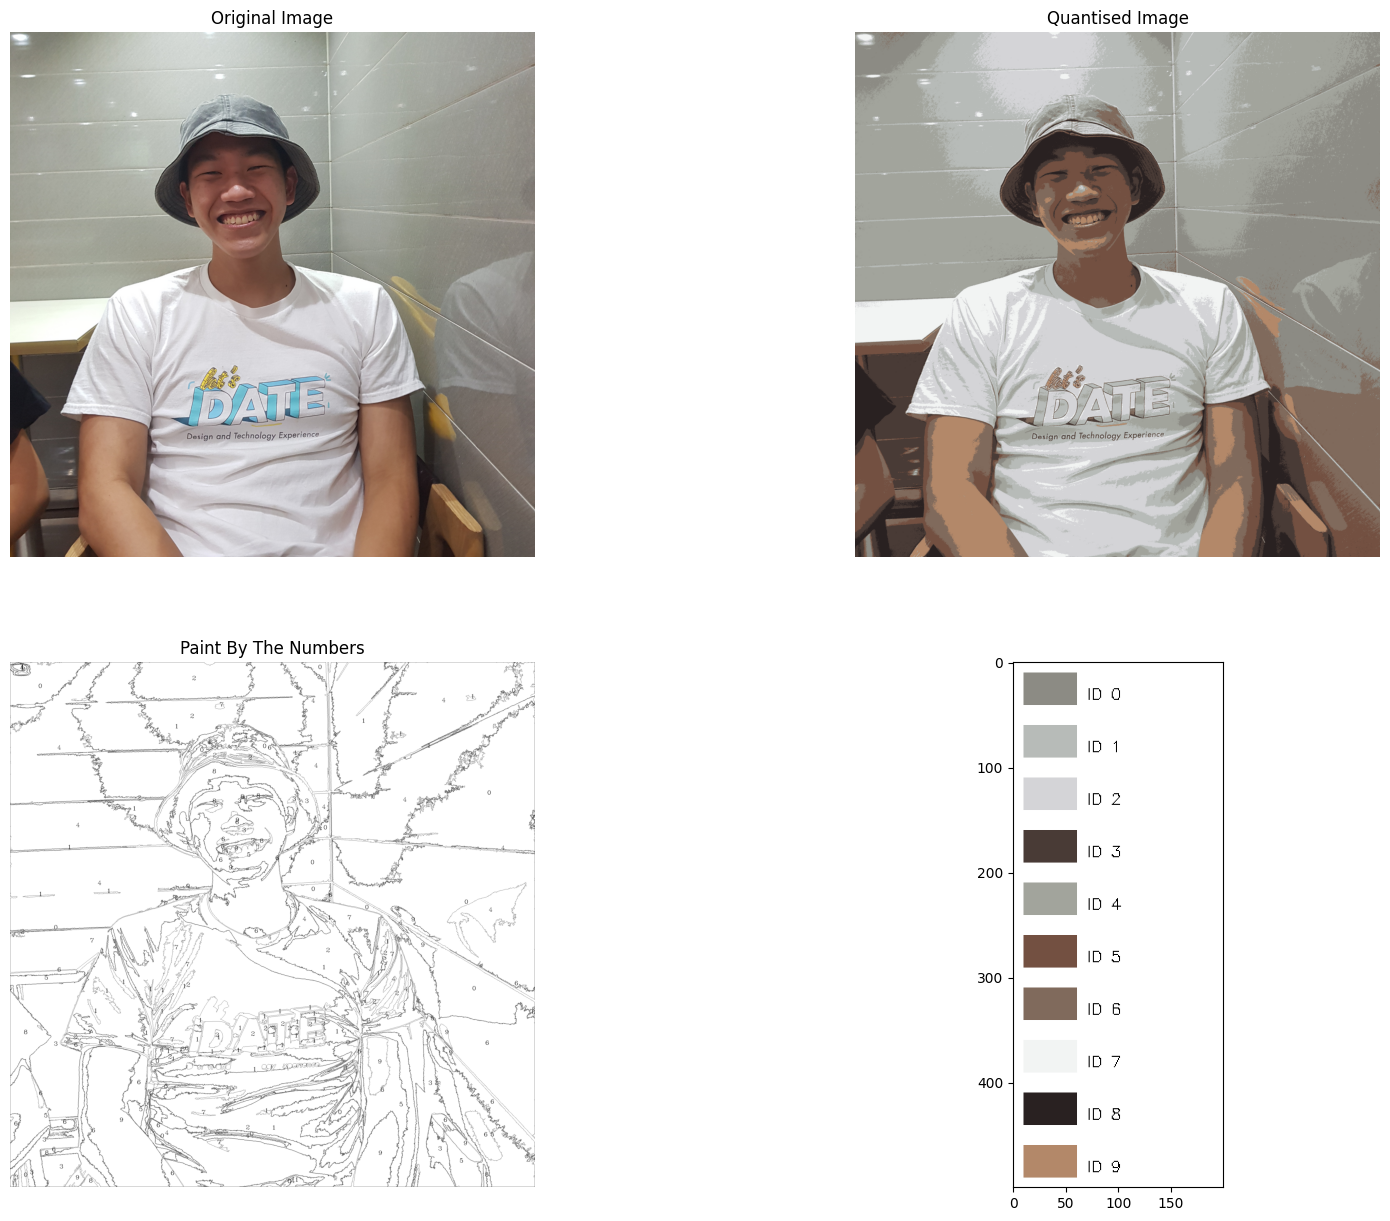

In [120]:
IMG_PATH = "data/img5.jpg"
K = 10

original_img, quantised_img, canvas = generate_paint_by_numbers(
  IMG_PATH,
  k=K,
  min_area_threshold=500,
  source_encoding="BGR"
)

# Edge Detection

In [ ]:
%watermark